# The Fashion MNIST - multiclass + CNN
Now we are back to the **fashion MNIST dataset**. This time we will use a CNN to process the images. For every image, we want to classify it into **10 distinct clothing categories**.

The big difference between processing images using a CNN compared to a dense network is that a **CNN** will process the images **"as images"**. This roughly means that we process the image by looking at pixels close together in the image and detect patterns in pixel values.

In this notebook, we will process the image by using a **convolutional layers**. The **more layers we add, the more complex patterns** can be detected. This approach is more reasonable than a naive approach (dense) since we use way **fewer parameters** by applying the same filter on many locations in the image.

Convolutional layers in Keras expect the input to have 3D dimensions `(width, height, colours)` but in the Fashion MNIST dataset each image is 2D, `(width, height)`. This is because the images are grayscale (range from black to white). If an image has colour, which consists of 3 colour values per pixel; Red, Green, Blue, we need to add an additional dimension to our tensor, making it 3D. This means that we need to add one dimension to our data. We will use the reshape function to achieve this. This means that our whole dataset will become a 4D tensor with dimensions `(examples, width, height, colours)` the training set this will have dimension `(60000, 28, 28, 1)`.

We will preprocess the data by first scaling the data using **Min/Max scaling**, map the labels to their **one-hot encoding representation** and then reshape the training data. Today we will not split the dataset further as we are provided with the train and test sets. After preprocessing the data we will then create a simple CNN to solve the multiclass classification task by using a **softmax layer** at the end which outputs a 10 class probability distribution and train the CNN using **categorical_crossentropy**. 

Let's load the data set:

In [1]:
library(tensorflow)
library(keras)
source("06-helpers.R")

use_multi_cpu(2L)

data <- dataset_fashion_mnist()

Let us quickly inspect the dimensions of our dataset so that we see how many examples we have and the size of the images.

In [2]:
dim(data$train$x)
length(data$train$y)
dim(data$test$x)
length(data$test$y)

[1] 60000    28    28

[1] 60000

[1] 10000    28    28

[1] 10000

These are 60000 training images, each one is 28 by 28 pixels. These are grayscale images, so the "colour" ranges from 0 (black) to 255 (white). Let's print out a single pixel in the first image.

In [3]:
data$train$x[1,15,15]

[1] 217

## 1. Preprocessing
As a first step in our preprocessing we scale the images by making sure that the maximum value each feature (pixel) takes is at most 1 and the minimum is 0. To do this use Min/Max scaling.

$$
x' = \frac{x - \min(\boldsymbol{x})}{\max(\boldsymbol{x}) - \min(\boldsymbol{x})}
$$

Where $x$ is a single example and $x'$ is our new scaled value. $\min(\boldsymbol{x})$ is the smallest value in the training set and $\max(\boldsymbol{x})$ is the largest value.

In this case we know that the minimum pixel value is 0 and the maximum is 255. This means that just need to divide each pixel value by 255.

## 1.1 Scale the train/test sets
Scale the train and test sets by dividing all of the pixel values by 255. For `data$train$x` store the result in `x_train_scaled` and for `data$test$x` store the result in `x_test_scaled`.

In [5]:
x_train_scaled <- data$train$x/255
x_test_scaled <- data$test$x/255

## 1.2 Reshaping
Next we reshape our data. We need to add one extra dimension to our data, otherwise the `layer_conv_2d` in Keras will complain. For each image a `(28, 28)` we need to reshape it into `(28, 28, 1)`. This is a change "on paper" and will not change anything.

[`Reshape`](https://rstudio.github.io/reticulate/reference/array_reshape.html) `x_train_scaled` and `x_test_scaled` to `c(60000, 28, 28, 1)` and `c(10000, 28, 28, 1)`, respectively. Check your work using the dim function. Store the result as `x_train` and `x_test`.

In [6]:
x_train <- array_reshape(x = x_train_scaled, dim = c(60000, 28, 28, 1))
x_test <- array_reshape(x = x_test_scaled, dim = c(10000, 28, 28, 1))
dim(x_train)

[1] 60000    28    28     1

## 1.3 One hot-encoding
We also need to preprocess the labels of the images. Each image in your dataset is associated with a certain label, what type of clothing it is. 

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

These labels range from 0 to 9. We need to map these labels to their corresponding one-hot encodings. We do this using the [`to_categorical()`](https://www.rdocumentation.org/packages/keras/versions/2.2.4/topics/to_categorical) function.

Apply this function to `data$train$y` and `data$test$y` and store the output in `y_train` and `y_test`, respectively. Verify your work with the `dim` function.

In [7]:
y_train = to_categorical(y = data$train$y, num_classes = 10)
y_test = to_categorical(y = data$test$y, num_classes = 10)
dim(y_train)
dim(y_test)

[1] 60000    10

[1] 10000    10

## 2. The models
Now we want to create a few simple CNN models. Let us start with a model which consists of a single convolutional layer.

## 2.1 A single conv layer
Create an initial model with the following properties.
- a 2d convolutional layer, `layer_conv_2d`, with `filters = 32`, `kernel_size = c(3, 3)`, `strides = c(2, 2)` and `padding = 'valid'`. For more information about the 2d conv layer see the [`layer_conv_2d`](https://www.rdocumentation.org/packages/keras/versions/2.2.4/topics/layer_conv_2d) documentation.
- After the `layer_conv_2d` apply the `layer_activation` with the `relu` activation function.
- Then flatten the output using `layer_flatten`.
- Then apply a `layer_dense` with 10 units and `softmax` activation.

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 13, 13, 32)              320         
________________________________________________________________________________
activation (Activation)             (None, 13, 13, 32)              0           
________________________________________________________________________________
flatten (Flatten)                   (None, 5408)                    0           
________________________________________________________________________________
dense (Dense)                       (None, 10)                      54090       
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
________________________________________________________________________________


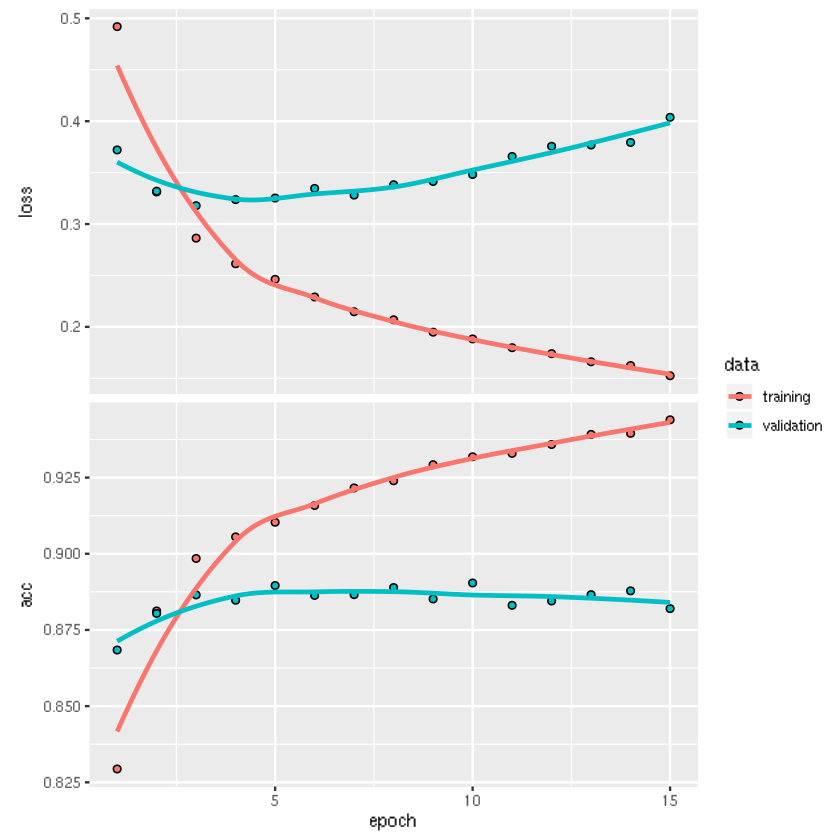

In [8]:
model <- keras_model_sequential() %>%
    layer_conv_2d(input_shape = c(28, 28, 1),
                  filters = 32, kernel_size = c(3, 3), 
                  strides = c(2,2), 
                  padding = 'valid') %>%
    layer_activation('relu') %>%
    layer_flatten() %>%
    layer_dense(units = 10, activation = "softmax")

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metric = "acc"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 15,
    batch_size = 256,
    callbacks=list(Progress$new())
)

plot(history)

Let us decipher this plot. 
- training loss continues to go down, this seems to imply that our model is sufficiently expressive.
- validation loss goes up in the end, we are overfitting.
- validation accuracy is fairly stable, our overfitting has not impacted our accuracy, yet.

Let us try to reduce overfitting in the next step.

## 2.2 Regularise
Let us add some dropout to our model in hopes of reducing overfitting. Copy the model from above and add `layer_dropout` after the `relu` activation. We used a dropout of `0.4` and discuss those results below.

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 13, 13, 32)              320         
________________________________________________________________________________
activation_1 (Activation)           (None, 13, 13, 32)              0           
________________________________________________________________________________
dropout (Dropout)                   (None, 13, 13, 32)              0           
________________________________________________________________________________
flatten_1 (Flatten)                 (None, 5408)                    0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 10)                      54090       
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________

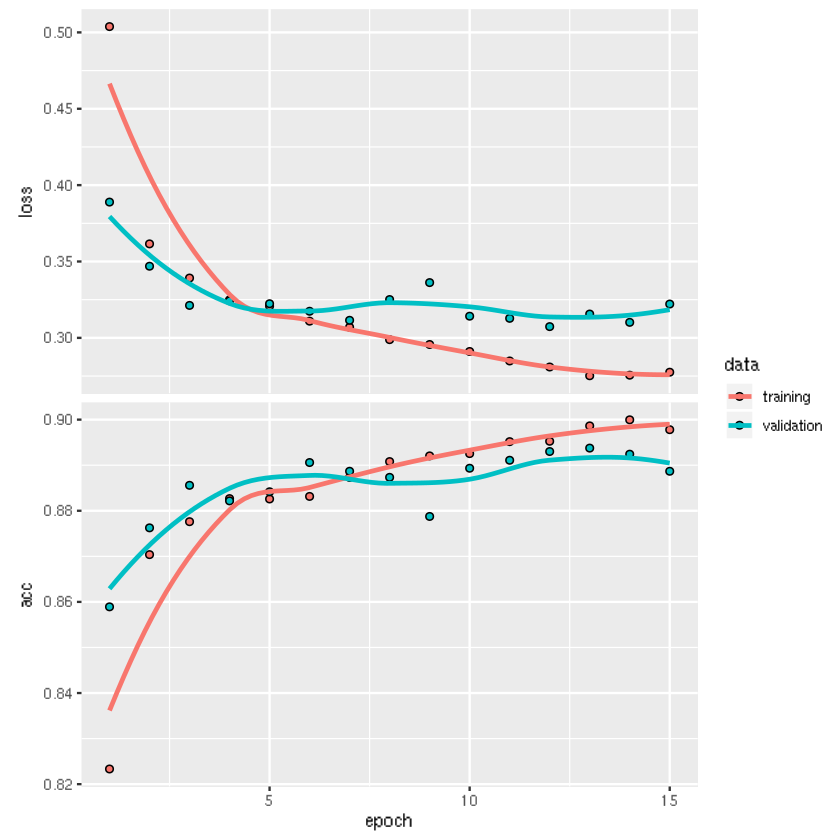

In [9]:
model <- keras_model_sequential() %>%
    layer_conv_2d(input_shape = c(28, 28, 1),
                  filters = 32, kernel_size = c(3, 3), 
                  strides = c(2,2), 
                  padding = 'valid') %>%
    layer_activation('relu') %>%
    layer_dropout(0.4) %>%
    layer_flatten() %>%
    layer_dense(units = 10, activation = "softmax")

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metric = "acc"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 15,
    batch_size = 256,
    callbacks=list(Progress$new())
)

plot(history)

Looking at this plot. We can see:
- Training loss seems to reduce slower now
- Validation loss is stable, thus less overfitting.

It seems that we could train this model longer and achieve better performance, but instead let us increase the complexity of the model by adding an additional convolutional layer. This will allow the model to detect more complex patterns which will undoubtably improve the performance of the model.

## 2.3 Two convolutional layers
Let us try increasing the model complexity by adding one more `layer_conv_2d` and `layer_activation` with `relu` to our model.
Copy the model from above and:
- add another `layer_conv_2d` and `layer_activation` with `relu` directly after the first `dropout` activation. Use the same parameters as first layer. Remove the `input_shape` parameter.
- Add dropout with 0.2 after the new `relu` activation.
- Reduce the dropout we specified earlier to 0.2.


Model: "sequential_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_2 (Conv2D)                   (None, 13, 13, 32)              320         
________________________________________________________________________________
activation_2 (Activation)           (None, 13, 13, 32)              0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 13, 13, 32)              0           
________________________________________________________________________________
conv2d_3 (Conv2D)                   (None, 6, 6, 32)                9248        
________________________________________________________________________________
activation_3 (Activation)           (None, 6, 6, 32)                0           
________________________________________________________________________________
dropou

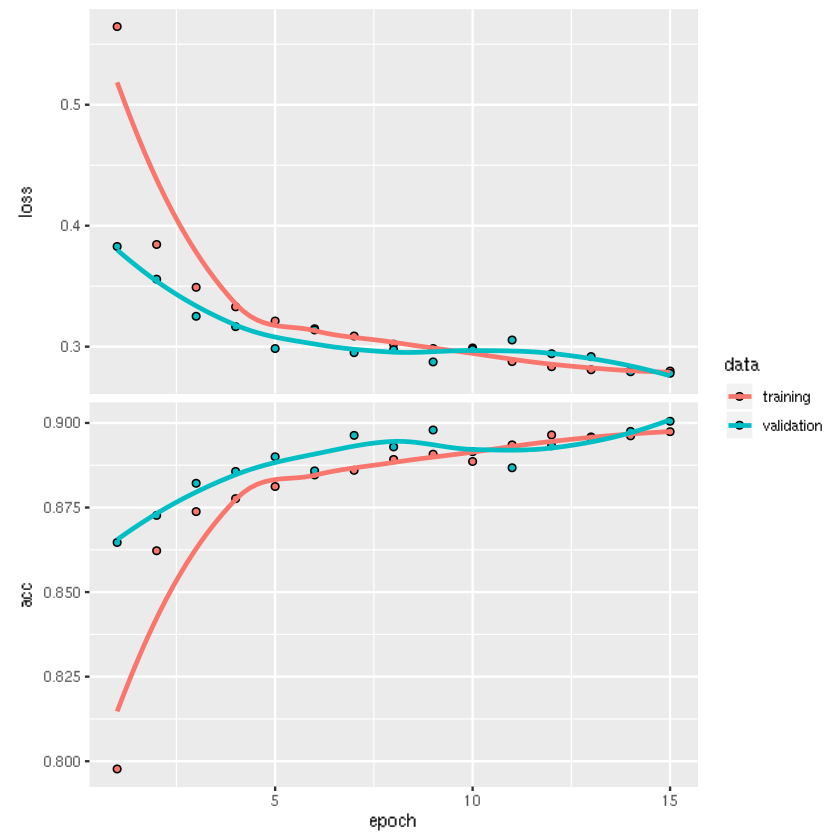

In [10]:
model <- keras_model_sequential() %>%
    layer_conv_2d(input_shape = c(28, 28, 1),
                  filters = 32, kernel_size = c(3, 3), 
                  strides = c(2,2), 
                  padding = 'valid') %>%
    layer_activation('relu') %>%
    layer_dropout(0.2) %>%
    layer_conv_2d(filters = 32, kernel_size = c(3, 3), 
                  strides = c(2,2), 
                  padding = 'valid') %>%
    layer_activation('relu') %>%
    layer_dropout(0.2) %>%
    layer_flatten() %>%
    layer_dense(units = 10, activation = "softmax")

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metric = "acc"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 15,
    batch_size = 256,
    callbacks=list(Progress$new())
)

plot(history)

From this plot we can see.
- Training loss and validation loss are close and decreasing slowly, this implies that we might want to increase model complexity to see if we can further improve our model.

We have improved our model somewhat from the initial model and we have without a doubt a better model than the dense network we trained in notebook 03a. You can confirm this be evaluating the model below.

We can continue improving this model, and we leave this as a bonus exercise.

In [11]:
model %>% evaluate(x_test, y_test)

$loss
[1] 0.293156

$acc
[1] 0.893

In this notebook we performed multi-class classification on the Fashion MNIST dataset. Today we processed the images using convolutional layers instead of a dense network. This allowed us to extra local pixel patterns and combine these patterns to create more complex patters. We started with a simple model using a single convolutional layer which we then slowly improved.

## Bonus exercise
Continue improving the model from 2.3. Try getting above 90% accuracy. Consider these options
- Add more convolutional layers (with activations)
- Add batch normalisation
- Increase the number of filters in later convolutional layers. 
- Add a dense later after all the convolutions but before the softmax.
- Use "same" padding in early convolutions.
- Adding more epochs

Model: "sequential_3"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_4 (Conv2D)                   (None, 14, 14, 32)              320         
________________________________________________________________________________
activation_4 (Activation)           (None, 14, 14, 32)              0           
________________________________________________________________________________
dropout_3 (Dropout)                 (None, 14, 14, 32)              0           
________________________________________________________________________________
conv2d_5 (Conv2D)                   (None, 7, 7, 64)                18496       
________________________________________________________________________________
activation_5 (Activation)           (None, 7, 7, 64)                0           
________________________________________________________________________________
dropou

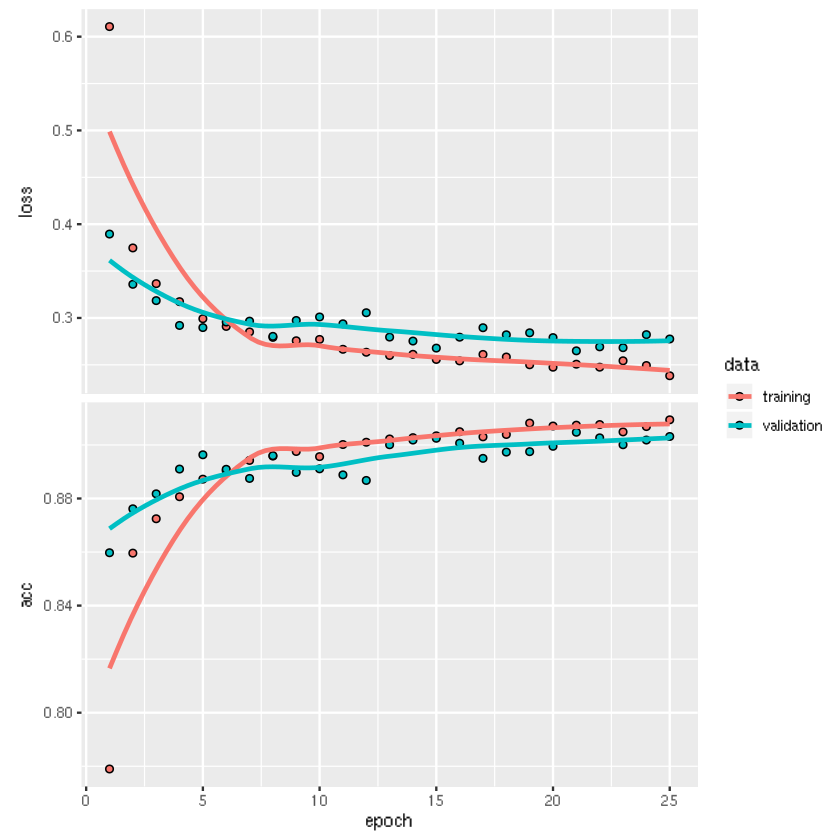

In [12]:
model <- keras_model_sequential() %>%
    layer_conv_2d(input_shape = c(28, 28, 1),
                  filters = 32, kernel_size = c(3, 3), 
                  strides = c(2,2), 
                  padding = 'same') %>%
    layer_activation('relu') %>%
    layer_dropout(0.2) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), 
                  strides = c(2,2), 
                  padding = 'same') %>%
    layer_activation('relu') %>%
    layer_dropout(0.2) %>%
    layer_conv_2d(input_shape = c(28, 28, 1),
                  filters = 64, kernel_size = c(3, 3), 
                  strides = c(2,2), 
                  padding = 'valid') %>%
    layer_activation('relu') %>%
    layer_flatten() %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dense(units = 10, activation = "softmax")

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metric = "acc"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 25,
    batch_size = 256,
    callbacks=list(Progress$new())
)

plot(history)